In [155]:
import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

np.random.seed(1)

# Open the AAPL stock file from the ticker_data dir
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data"
df = pd.read_csv(f"{TICKER_DIR}\\AXP.csv", header=0)

print(df.shape)

# Our target is the close price of the stock
target = df["close"].tail(1000)
dataset = df[["high", "low", "open"]].tail(1000)

(1006, 13)


In [156]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i, _ in enumerate(sequences):
		end_ix = i + n_steps
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n_steps = 3

high = dataset["high"].values.reshape(len(dataset), 1)
low = dataset["low"].values.reshape(len(dataset), 1)
open = dataset["open"].values.reshape(len(dataset), 1)
close = target.values.reshape(len(dataset), 1)

# stack them horizontally
d = np.hstack((open, high, low, close))
# split sequences
sc = MinMaxScaler()
d_sc = sc.fit_transform(d)
X, y = split_sequences(d_sc, n_steps)

n_features = X.shape[2]
print(d.shape)
print(X.shape)
print(y.shape)



(1000, 4)
(998, 3, 4)
(998, 4)


In [157]:
# clears previous sessions
keras.backend.clear_session()
# create a Sequential model, 2 LSTM 100 node layers & 1 fully connected layer
model = Sequential()
model.add(LSTM(100, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation="relu"))
model.add(Dense(n_features))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mae", metrics=["mae", "mse"])

# split dataset to training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

model.fit(X_train, y_train, epochs=500, verbose=2)

2 - mae: 0.0042 - mse: 3.5237e-05
Epoch 203/500
 - 0s - loss: 0.0040 - mae: 0.0040 - mse: 3.3452e-05
Epoch 204/500
 - 0s - loss: 0.0037 - mae: 0.0037 - mse: 3.0374e-05
Epoch 205/500
 - 0s - loss: 0.0037 - mae: 0.0037 - mse: 3.1091e-05
Epoch 206/500
 - 0s - loss: 0.0041 - mae: 0.0041 - mse: 3.3766e-05
Epoch 207/500
 - 0s - loss: 0.0039 - mae: 0.0039 - mse: 3.2423e-05
Epoch 208/500
 - 0s - loss: 0.0038 - mae: 0.0038 - mse: 3.1582e-05
Epoch 209/500
 - 0s - loss: 0.0040 - mae: 0.0040 - mse: 3.2353e-05
Epoch 210/500
 - 0s - loss: 0.0047 - mae: 0.0047 - mse: 4.0889e-05
Epoch 211/500
 - 0s - loss: 0.0043 - mae: 0.0043 - mse: 3.6816e-05
Epoch 212/500
 - 0s - loss: 0.0037 - mae: 0.0037 - mse: 2.9456e-05
Epoch 213/500
 - 0s - loss: 0.0045 - mae: 0.0045 - mse: 3.8118e-05
Epoch 214/500
 - 0s - loss: 0.0039 - mae: 0.0039 - mse: 3.2066e-05
Epoch 215/500
 - 0s - loss: 0.0039 - mae: 0.0039 - mse: 3.2094e-05
Epoch 216/500
 - 0s - loss: 0.0039 - mae: 0.0039 - mse: 3.2435e-05
Epoch 217/500
 - 0s - loss: 

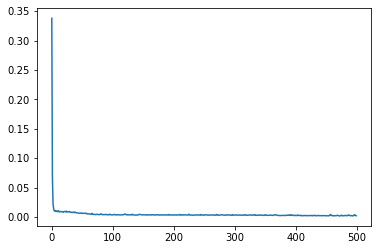

In [158]:
# plot the model's loss history
model.history.history.keys()
plt.plot(model.history.history["loss"])

In [159]:
# evaluate the model with the testing datasets
scores = model.evaluate(X_test, y_test, verbose=0)
print(*[f"History Item [{item}] reports value of {value}" for value, item in zip(scores, model.metrics_names)], sep="\n")

History Item [loss] reports value of 0.004127556532621384
History Item [mae] reports value of 0.004127556458115578
History Item [mse] reports value of 2.6321024051867425e-05


In [160]:
# take the last 36 close values for testing
# 36 is the size of the testing set
# actual = df["close"].tail(X_test.shape[0]).values
# sc.data_range_

actual = y_test[:, -1]
yhat = model.predict(X_test, verbose=0)
yhat.shape
predictions = yhat[:, -1]

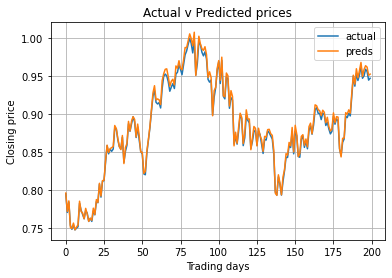

In [161]:
# plot the predicted values against the actual values
fig = plt.figure()
plt.title("Actual v Predicted prices")
plt.ylabel("Closing price")
plt.xlabel("Trading days")
plt.plot(actual, label="actual")
plt.plot(predictions, label="preds")
plt.grid()
plt.legend()
# plt.savefig("C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\MSFT.png")